In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
from annoy import AnnoyIndex
import torch.autograd as autograd
from typing import List
import anndata
from functools import partial
from copy import deepcopy

from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import math
import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
import colorcet as cc

import math
from scipy import sparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.utils.spectral_norm as spectral_norm
import torch.nn.utils.weight_norm as weight_norm
import torch.optim.lr_scheduler as lr_scheduler
import scanpy as sc
import time
import os
from scipy import sparse
from adabelief_pytorch import AdaBelief
import torch.quantization

import gzip

from torch.utils.data import WeightedRandomSampler

from utils.explanation_utils import explanation_hook, get_explanation
from sklearn.preprocessing import MinMaxScaler
import gc

torch.cuda.set_device(3)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = False # change to True for reproducible
    torch.backends.cudnn.benchmark = True

from anndata import AnnData
    
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# import warnings
# warnings.filterwarnings("ignore")

path= "../"

# check available files
# !ls ../real_data

torch.autograd.set_detect_anomaly(True)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

########## NEURAL NETWORK UTILITY ##########
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

CPUTensor =  torch.FloatTensor

In [2]:
## /acrc/jinmiao/CJM_lab/hoatran/demo_normalization/dataset/dataset5_human_pbmc/raw_data_python/myTotalData.h5ad

In [3]:
dataset = "simul1_dropout_47_b1_1000_b2_2000"
cellinfo_df = pd.read_csv('%s/cellinfo.txt' % (dataset), sep="\t")
counts_df = pd.read_csv('%s/counts.txt' % (dataset), sep="\t")
de_genes_df = pd.read_csv('%s/de_genes.txt' % (dataset), sep="\t")
geneinfo_df = pd.read_csv('%s/geneinfo.txt' % (dataset), sep="\t")
true_down_genes_df = pd.read_csv('%s/true_down_genes.txt' % (dataset), sep="\t")
true_up_genes_df = pd.read_csv('%s/true_up_genes.txt' % (dataset), sep="\t")
true_counts = pd.read_csv('%s/truecounts.txt' % (dataset), sep="\t").values.transpose()

In [4]:
true_counts.shape

(8000, 5000)

In [5]:
from anndata import AnnData

adata = AnnData(X=counts_df.transpose(), obs=cellinfo_df.iloc[:, 1:],
                    dtype='float32')

# obs_label_colname ="celltype"
adata

AnnData object with n_obs × n_vars = 8000 × 5000
    obs: 'Batch', 'Group', 'ExpLibSize'

In [6]:
# true_counts = true_counts.astype('float')

# true_counts = sc.pp.normalize_per_cell(true_counts, counts_per_cell_after=1e4, copy = True)
# true_counts = np.log1p(true_counts)

In [7]:
# adata.obsm["X_pca_true"] = sc.pp.pca(true_counts, copy = True)

In [8]:
# sc.pp.neighbors(adata, use_rep='X_pca_true', n_neighbors=30)
# # sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
# sc.tl.umap(adata)

In [9]:
# # adata.obsm["X_latent"] = output_results

# # sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=30)
# # sc.external.pp.bbknn(adata, batch_key='batch', use_rep='X_latent')
# # sc.tl.umap(adata)
# sc.pl.umap(adata, color=["Batch","Group"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [10]:
le = preprocessing.LabelEncoder()
new_batch = le.fit_transform(adata.obs["Batch"])
adata.obs["Batch"] = new_batch

new_batch = [str(each) for each in new_batch]
adata.obs["Batch_num"] = new_batch

# change also for the groups we want to preserve
le_2 = preprocessing.LabelEncoder()
new_groups = le_2.fit_transform(adata.obs["Group"])
new_groups = [int(each) for each in new_groups]
# new_groups = [str(each) for each in new_groups]
adata.obs["Group"] = new_groups

adata.obs["Group_num"] = le_2.inverse_transform(adata.obs['Group'])
adata.obs["Group_num"] = [str(each) for each in adata.obs["Group_num"]]

In [11]:
adata.layers["counts"] = adata.X

In [12]:
# # create dataset based on the text file

# b1_obs = pd.read_csv("dataset5/b1_celltype.txt", sep = "\t", index_col = 0)
# b2_obs = pd.read_csv("dataset5/b2_celltype.txt", sep = "\t", index_col = 0)

# b1_expr = pd.read_csv("dataset5/b1_exprs.txt", sep = "\t", index_col = 0).values.transpose()
# b2_expr = pd.read_csv("dataset5/b2_exprs.txt", sep = "\t", index_col = 0).values.transpose()

# b1_obs["batch"] = "0"
# b2_obs["batch"] = "1"

# full_expr = np.concatenate((b1_expr, b2_expr), axis=0)
# full_obs = pd.concat([b1_obs, b2_obs])

# adata = AnnData(X=full_expr, obs=full_obs, dtype='float32')

# adata.write_h5ad("data/pbmc.h5ad")

In [13]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

def compute_ari(adata):

    resolutions = None

    if resolutions is None:
        n = 20
        resolutions = [2 * x / n for x in range(1, n + 1)]

    score_max = 0
    res_max = resolutions[0]
    clustering = None
    score_all = []
    use_rep = "X_pca"
    cluster_key = "louvain"
    label_key = "Group"
    sc.pp.neighbors(adata, use_rep=use_rep)

    for res in resolutions:
        sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
        score = ari(adata, label_key, cluster_key)
        score_all.append(score)
        if score_max < score:
            score_max = score
            res_max = res
            clustering = adata.obs[cluster_key]

    return score_max

In [14]:
sc.__version__

'1.9.3'

In [15]:
# flavor: seurat_v3, cell_ranger & log = false
def sub_data_preprocess(adata: sc.AnnData, n_top_genes: int = 5000, batch_key: str = None, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3) -> sc.AnnData:
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)
#     if flavor == 'seurat_v3':
# # #         count data is expected when flavor=='seurat_v3'
# #         sc.pp.highly_variable_genes(
# #             adata, flavor=flavor, batch_key = batch_key)
#         sc.pp.highly_variable_genes(
#             adata, flavor=flavor, batch_key = batch_key, n_top_genes=n_top_genes)

#     if flavor != 'seurat_v3':.
#         # log-format data is expected when flavor!='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, n_top_genes=n_top_genes, flavor=flavor)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    return adata


def data_preprocess(adata: sc.AnnData, key: str = 'batch', n_top_genes: int = 10000, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3, n_batch: int = 2) -> sc.AnnData:
    print('Establishing Adata for Next Step...')
    hv_adata = sub_data_preprocess(adata, n_top_genes=n_top_genes, batch_key = key, flavor=flavor, min_genes=min_genes, min_cells=min_cells)
#     if len(adata.var.index) > n_top_genes:
#         hv_adata = hv_adata[:, hv_adata.var['highly_variable']]
#     hv_adata.X = np.expm1(hv_adata.X)
    print('PreProcess Done.')
    return hv_adata

In [16]:
batch_str = "Batch_num"

adata = data_preprocess(adata, batch_str)
adata  # Output the basic information of the preprocessed data.

Establishing Adata for Next Step...
PreProcess Done.


AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [17]:
adata.layers["log_norm"] = adata.X

In [18]:
setup_seed(8)

In [19]:
# import scanpy as sc
# import pandas as pd
# import seaborn as sns

# # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.settings.verbosity = 1
# sc.settings.set_figure_params(
#     dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

# # check the umap after normalisation

# # compute pca and neighbor for calculating the ARI score
# # sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata, n_neighbors=30)
# sc.tl.umap(adata)

# # sc.pl.umap(adata, color=['batch', 'CellType'],
# #            palette=sc.pl.palettes.vega_20_scanpy)

# # revert based to unscale data
# # adata.X = adata.layers["log_norm"]

In [20]:
# sc.pl.umap(adata, color=['Batch_num'],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [21]:
# sc.pl.umap(adata, color=['Group_num'],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [22]:
# dataset = "simul111_dropout_1_b1_1000_b2_2000"

# # true_down_genes_df = pd.read_csv('%s/true_down_genes.txt' % (dataset), sep="\t")
# # true_up_genes_df = pd.read_csv('%s/true_up_genes.txt' % (dataset), sep="\t")
# true_counts = pd.read_csv('%s/counts.txt' % (dataset), sep="\t").values.transpose()

# true_counts = true_counts.astype('float')

# true_counts = sc.pp.normalize_per_cell(true_counts, counts_per_cell_after=1e4, copy = True)
# true_counts = np.log1p(true_counts)

# subset_index = [int(each[4:]) - 1 for each in adata.obs.index.values]
# subset_genes = [int(each[4:]) - 1 for each in adata.var.index.values]
# true_counts = true_counts[subset_index]
# true_counts = true_counts[:, subset_genes]

In [23]:
# adata.obsm["X_pca_true"] = sc.pp.pca(true_counts, copy = True)

# sc.pp.neighbors(adata, use_rep='X_pca_true', n_neighbors=30)
# # sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
# sc.tl.umap(adata)

In [24]:
# # adata.obsm["X_latent"] = output_results

# # sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=30)
# # sc.external.pp.bbknn(adata, batch_key='batch', use_rep='X_latent')
# # sc.tl.umap(adata)
# sc.pl.umap(adata, color=["Batch_num","Group_num"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [25]:
# adata.layers["X_raw"] = adata.X.copy()

In [26]:
# raw_array = adata.layers["X_raw"]

# # Flatten the 2D array to 1D
# flattened_array = raw_array.flatten()

# fig, ax = plt.subplots()
# a = np.amin(raw_array)
# b = np.amax(raw_array)
# ax.hist(flattened_array, bins=np.arange(a, b, (b-a)*0.03), alpha=1.0, rwidth=0.90, color='salmon')

# # generate the percentage of zeroes and negative values in the array
# percent_zeros = (raw_array == 0).mean()
# percent_negatives = (raw_array < 0).mean()

# # Remove the top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # Add labels and title to the plot
# ax.set_xlabel('Values')
# ax.set_ylabel('Log Frequency')
# plt.yscale('log')
# # plt.title("Histogram of Gene Expression")

# plt.annotate("Zeros values: {:.2f}%\nNegatives values: {:.2f}%".format(percent_zeros * 100, percent_negatives * 100),
#              xy=(0.98, 0.98), xycoords="axes fraction", fontsize=10, ha="right", va="top",
#              bbox=dict(boxstyle="round", facecolor="mistyrose", alpha=0.5))

# # Show the plot
# plt.show()

In [27]:
# # Define the colorcet paletteasdasd
# custom_palette = cc.glasbey_category10

# ax = sc.pl.umap(adata, color='Method', palette=custom_palette,
#            frameon=False, legend_fontsize=3.5, show=False)

# # Set the plot title with the desired font size
# ax.set_title('Predicted Cell Type', fontsize=6)

# # Adjust the legend font size
# handles, labels = plt.gca().get_legend_handles_labels()

# # Adjust the size of the circles
# for handle in handles:
#     handle.set_sizes([12])
#     handle.set_edgecolor('black')
#     handle.set_linewidth(0.5)

# # Move the legend to the right side of the plot
# plt.legend(handles=handles, labels=labels, prop={'size': 5}, ncol = 1, 
#            loc='upper center', bbox_to_anchor=(0.5, -0.08))

# # Show the plot
# plt.show()

In [28]:
from sklearn.preprocessing import OneHotEncoder

# le = preprocessing.LabelEncoder()
enc_batch = OneHotEncoder(handle_unknown='ignore')
enc_group = OneHotEncoder(handle_unknown='ignore')

label_str = "Batch"
group_str = "Group"

enc_batch.fit(adata.obs[label_str].to_numpy().reshape(-1, 1))
enc_group.fit(adata.obs[group_str].to_numpy().reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [29]:
########## CLASS SINGLE CELL DATASET ##########
class ScDataset(Dataset):
    def __init__(self, adata):
        self.variable = None
        self.labels = adata.obs[label_str].to_numpy()
        self.org_batch = adata.obs[label_str].to_numpy()
        self.groups = adata.obs[group_str].to_numpy()
        self.one_hot_labels = enc_batch.transform(adata.obs[label_str].to_numpy().reshape(-1, 1)).toarray()
        self.one_hot_groups = enc_group.transform(adata.obs[group_str].to_numpy().reshape(-1, 1)).toarray()
        try:
            self.X = adata.X.toarray()
#             self.hvg_X = adata[:, adata.var['highly_variable']].X.copy().toarray()
        except:
            self.X = adata.X
        
        self.min_val = np.amin(adata.X)
        self.max_val = np.amax(adata.X)
#         self.groups = adata.obs[group_str].to_numpy()
        self.transform = None
        self.sample = None
        self.adata = adata
#         self.random_target = np.eye(c_dim)[np.random.choice(c_dim, len(self.labels))]
        
#             self.hvg_X = adata[:, adata.var['highly_variable']].X.copy()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
#         random_index = random.randint(0, self.X.shape[0] - 1)

        return self.X[index], self.labels[index], self.one_hot_labels[index], self.groups[index], self.one_hot_groups[index]

In [30]:
label_str = "Batch"

# split per batch into new objects.
batches = list(set(adata.obs[label_str]))
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs[label_str] == batch,]

length_data = []

for batch in batches:
    length = len(alldata[batch])
    
    length_data.append(length)
anchor_index = np.argmax(length_data)

In [31]:
batches[anchor_index]

3

### pre processing step for normalise and scale the for each individual batch

In [32]:
# # apply the pre processing onto the anndata
# # first create layer for the anndata

adata.layers["X_raw"] = adata.layers["log_norm"]

In [33]:
adata.X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.1481607, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

## compute ARI score for each batch

In [34]:
# # split per batch into new objects.
# batches = list(set(adata.obs[label_str]))
# alldata = {}
# for batch in batches:
#     alldata[batch] = adata[adata.obs[label_str] == batch,]
    
# # subset only the batches with good ARI score
# subset_batches = []

# # max_ari = 0
    
# for each in batches:
#     print("batch: %s" % each)
#     ari_score = compute_ari(alldata[each])
#     print(ari_score)
#     if ari_score > 0.50:
#         subset_batches.append(each)
        
# #     if ari_score > max_ari:
# #         max_ari = ari_score
# #         batch_anchor = each
        

# # then subset the adata for training the model
# # save the test dataset first
# adata = adata.copy()
# adata_temp = adata[adata.obs["batch"].isin(subset_batches)].copy()

In [35]:
# try try using the normalised data as the input

# adata.X = adata.layers["X_norm"].copy()

In [36]:
# adata.X = adata.X.toarray().copy()

## Normalise the sequencing depth which is the library size

The the batch effect removal starting from removing the library size and then remove the actual batch effect from the technical different.

**Previous issue**: we select one batch as the anchor which become and issue when that batch does not seperate cell type well enough as compare to other batch. Hence, we now change to batch free without selecting any anchored batch. 

In [37]:
# import scanpy as sc
# import pandas as pd
# import seaborn as sns

# # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.settings.verbosity = 1
# sc.settings.set_figure_params(
#     dpi=150, frameon=False, figsize=(3, 3), facecolor='white')

# # adata.X = adata.layers["X_scaled"].copy()
# # check the umap after normalisation

# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['batch', 'celltype'],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [38]:
max_val = np.amax(adata.X)
min_val = np.amin(adata.X)

print("Upper bound of the gene expression: ", max_val)
print("Lower bound of the gene expression: ", min_val)

Upper bound of the gene expression:  7.118697
Lower bound of the gene expression:  0.0


In [39]:
def calculate_div_gp(prob_real_data, prob_fake_data, real_data, fake_data, k=2, p=6):
# #     real_data = Variable(real_data, requires_grad=True)
#     prob_real_data, _, = D(real_data)

    real_grad_outputs = torch.ones(prob_real_data.size()).cuda() if cuda else torch.ones(prob_real_data.size())

    fake_data.requires_grad_(True)
#     prob_fake_data, _, = D(fake_data)

    fake_grad_outputs = torch.ones(prob_fake_data.size()).cuda() if cuda else torch.ones(prob_fake_data.size())

    real_gradient = torch.autograd.grad(
        outputs=prob_real_data,
        inputs=real_data,
        grad_outputs=real_grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    fake_gradient = torch.autograd.grad(
        outputs=prob_fake_data,
        inputs=fake_data,
        grad_outputs=fake_grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True, 
    )[0]

    real_gradient_norm = real_gradient.view(real_gradient.size(0), -1).pow(2).sum(1) ** (p / 2)
    fake_gradient_norm = fake_gradient.view(fake_gradient.size(0), -1).pow(2).sum(1) ** (p / 2)

    gradient_penalty = torch.mean(real_gradient_norm + fake_gradient_norm) * 1.
     
    return gradient_penalty 

In [40]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.kaiming_normal_(m.weight.data, 0.2)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if classname.find("Conv") != -1:
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
#     elif classname.find("BatchNorm") != -1:
#         torch.nn.init.normal_(m.weight, 1.0, 0.02)
#         torch.nn.init.zeros_(m.bias)

In [41]:
class AFF(nn.Module):
    def __init__(self, dim):
        super(AFF, self).__init__()

        # attentional feature fusion layer
        self.sigmoid = nn.Sigmoid()

        self.attention = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(inplace=True),
            nn.Linear(dim, dim),
           # nn.BatchNorm1d(dim),
        )
        
    def forward(self, latent_data, style_latent):
        # fusion layer before decoder
        xa = latent_data + style_latent
        xl = self.attention(xa)
        wei = self.sigmoid(xl)

        data = latent_data * wei + style_latent * ((1 - wei))
        return data

In [42]:
def combine(a, b):
    return torch.cat((a, b), -1)

In [43]:
class GeneExpressionAttention(nn.Module):
    def __init__(self, n_features, d_k, bias = True):
        super(GeneExpressionAttention, self).__init__()
        self.d_k = d_k
        self.bias = bias
        
        # query representation
        self.W_Q = nn.Linear(n_features, d_k, self.bias)
        
        # key and value pair to attend to
        self.W_K = nn.Linear(n_features, d_k, self.bias)
        self.W_V = nn.Linear(n_features, d_k, self.bias)
        
        # multihead attention
#         self.multi_atten = nn.MultiheadAttention(d_k, 4, kdim = n_features, vdim = n_features, batch_first = True)

#         self.encoder = nn.GRU(n_features, d_k, num_layers = 1, bidirectional = False, batch_first = True)

    def forward(self, tabular_data):
        # Project tabular data into Q, K, and V matrices
        Q = self.W_Q(tabular_data)
        K = self.W_K(tabular_data)
        V = self.W_V(tabular_data)
        
        Q, K, V = Q.unsqueeze(1), K.unsqueeze(1), V.unsqueeze(1)
        
#         attn_output, attn_output_weights = self.multi_atten(Q, K, V)
        
#         return attn_output.squeeze(1)

        return F.scaled_dot_product_attention(Q,K,V, is_causal = True).squeeze(1)

In [44]:
class TrainableWeightedSum(nn.Module):
    def __init__(self):
        super(TrainableWeightedSum, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(2))  # Create learnable weights
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.weights)  # Initialize weights with uniform distribution

    def forward(self, tensor1, tensor2):
        # Apply element-wise multiplication to the input tensors
        weighted_tensor1 = torch.mul(tensor1, self.weights[0])
        weighted_tensor2 = torch.mul(tensor2, self.weights[1])

        # Sum the weighted tensors
        fused_tensor = torch.add(weighted_tensor1, weighted_tensor2)

        return fused_tensor

class LinearAttention(nn.Module):
    def __init__(self, in_features, out_features, bias = True):
        super(LinearAttention, self).__init__()
        
        self.feed_forward  = nn.Sequential(
            nn.Linear(in_features, in_features, bias),
            nn.ReLU(),
            nn.Linear(in_features, in_features, bias),
            nn.Dropout(0.1),
        )
        
        self.gamma = nn.Parameter(torch.zeros(1))  # Create learnable weights
        
        self.atten = GeneExpressionAttention(in_features, in_features, bias)
#         self.weighted_sum = TrainableWeightedSum()
#         self.weighted_sum.cuda()

        self.norm1 = nn.BatchNorm1d(in_features)
        self.norm2 = nn.BatchNorm1d(out_features)
        
        # Dropout
        self.dropout = nn.Dropout(0.1)
        
        # output layer
        
        self.out = nn.Linear(in_features, out_features, bias)

    def forward(self, x):
        atten_out = self.norm1(self.dropout(self.gamma * self.atten(x)) + x)
#         atten_out_2 = self.atten2(x)
        out = self.feed_forward(atten_out)
        out = atten_out + self.dropout(out)
        out = self.norm2(out)
        return self.out(out)

In [45]:
from utils.sophia import SophiaG
from utils.acprop import ACProp
# from pytorch_optimizer import *
from adabelief_pytorch import AdaBelief
from pytorch_optimizer import clip_grad_norm

In [46]:
# scaled_X, min_val, max_val = minmax_scale(adata.X)

In [47]:
# adata.X = scaled_X

In [48]:
initial_dropout_rate = 0.8
final_dropout_rate = 0.25
stabilization_epochs = 200
dropout_anneal_epochs = 500 - stabilization_epochs
dropout_decay = (initial_dropout_rate - final_dropout_rate) / dropout_anneal_epochs

# Function to anneal the dropout rate
def anneal_dropout_rate(epoch):
    if epoch < stabilization_epochs:
        return initial_dropout_rate
    else:
        return max(initial_dropout_rate - dropout_decay * (epoch - stabilization_epochs), final_dropout_rate)

In [49]:
from torch.nn.utils.parametrizations import orthogonal

In [50]:
def normalised(x, min_val, max_val):
    return -1 + 2 * (x - min_val) / (max_val - min_val)

def denormalised(x_normalized, min_val, max_val):
    return min_val + (x_normalized + 1) * 0.5 * (max_val - min_val)

In [51]:
from dog import DoG, LDoG
from dog import PolynomialDecayAverager

In [52]:
def train(scd, n_epochs):
#     n_epochs = n_epochss
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_size = scd.X.shape[1]
    lr = 0.0001
    b1 = 0.5
    b2 = 0.999
    latent_dim = 32
#     style_dim = latent_dim
    embedding_dim = 16
    n_dim = 1024
#     proj_dim = 2000
    n_critic = 5
    global c_dim, ctype_dim
    c_dim = len(list(set(adata.obs[label_str])))
    g_dim = len(list(set(adata.obs[group_str])))
    
    # early stopping function
    trigger_times = 0
    best_loss = 100.0
    
    # condition for when we don't have anything to preserve
    con_dim = c_dim
    
    act_func = nn.ReLU(inplace = True)

    class Generator(nn.Module):
        def __init__(self, dropout_rate = 0.16, res_blocks = 3):
                super(Generator, self).__init__()
                self.relu = nn.ReLU(inplace = True)
                self.dropout_rate = dropout_rate
                
                # encoder for the gene expression
                self.encoder = nn.Sequential(
#                     self.proj, # adding projection layer
                    GeneExpressionAttention(data_size + embedding_dim * 2, n_dim),
                    nn.BatchNorm1d(n_dim),
                    nn.Dropout(self.dropout_rate),
                    nn.LeakyReLU(0.2, inplace = True),
                    nn.Linear(n_dim, n_dim // 2),
                    nn.BatchNorm1d(n_dim // 2),
                    nn.Dropout(self.dropout_rate),
                    nn.LeakyReLU(0.2, inplace = True),
                    nn.Linear(n_dim // 2, latent_dim),
#                     nn.BatchNorm1d(latent_dim),
#                     nn.Dropout(self.dropout_rate),
#                     act_func,
                )
                
                # create a share decoder
                self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, n_dim // 2),
                    nn.BatchNorm1d(n_dim // 2),
                    nn.Dropout(self.dropout_rate),
                    nn.LeakyReLU(0.2, inplace = True),
                    nn.Linear(n_dim // 2, n_dim),
                    nn.BatchNorm1d(n_dim),
                    nn.Dropout(self.dropout_rate),
                    nn.LeakyReLU(0.2, inplace = True),
                    nn.Linear(n_dim, data_size),
                )
                
                
                self.embedding_layer_c = nn.Sequential(
                    nn.Embedding(c_dim, embedding_dim),
                )
                
                self.embedding_layer_g = nn.Sequential(
                    nn.Embedding(g_dim, embedding_dim),
                )
 
        def forward(self, x, c, g, test = False):
        
            batch_size = x.shape[0]
            # when the model is trained, we discard the c label
            if test == True:
                # zero out to remove this attribute from the model
                c_embeddings = torch.zeros(batch_size, embedding_dim, device = x.device)
            else:
                c_embeddings = self.embedding_layer_c(c)
            
            g_embeddings = self.embedding_layer_g(g)
            data = torch.cat((x, c_embeddings, g_embeddings), -1)
            
#             out_proj = self.proj(data)
#             atten_out = self.atten_out(data) + self.random_atten_out(data)
        
            # content network
            latent_data = self.encoder(data)
#             latent_data = self.resnet(latent_data)
            corrected_data = self.decoder(latent_data)
#             atten_corrected = self.decoder(atten_out)
            
            return corrected_data
    
    class Discriminator(nn.Module):
        def __init__(self, dropout_rate = 0.16):
            super(Discriminator, self).__init__()
            
#             self.self_att = nn.Sequential(
#                     GeneExpressionAttention(data_size, embedding_dim),
#                     LinearAttention(embedding_dim, embedding_dim),
#             )
            
            self.dropout_rate = dropout_rate
            
            self.model = nn.Sequential(
                GeneExpressionAttention(data_size, n_dim), # adding projection layer
                nn.BatchNorm1d(n_dim),
                nn.Dropout(self.dropout_rate),
                nn.LeakyReLU(0.2, inplace = True),
                nn.Linear(n_dim, n_dim // 2),
                nn.BatchNorm1d(n_dim // 2),
                nn.Dropout(self.dropout_rate),
                nn.LeakyReLU(0.2, inplace = True),
                nn.Linear(n_dim // 2, latent_dim),
                nn.BatchNorm1d(latent_dim),
                nn.LeakyReLU(0.2, inplace = True),
            )
        
            # Output layers
            self.adv_layer = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(latent_dim, 1)
                ) for _ in range(c_dim + g_dim)
            ])
            
            # Classify layers
            self.cls_layer_c = nn.Sequential(
                nn.Linear(latent_dim, c_dim),
            )
            
            # classifying groups
            self.cls_layer_g = nn.Sequential(
                nn.Linear(latent_dim, g_dim),
            )

        def forward(self, data):
          #  data = torch.cat((data, label), -1)
#             atten = self.self_att(data)
            out = self.model(data)
#             out = self.residual(out)
            # shortcut connection with attention embeddings
#             out = combine(out, atten)
            validity = [adv(out) for adv in self.adv_layer]
    
            classify_c = self.cls_layer_c(out)
            classify_g = self.cls_layer_g(out)
            return validity, classify_c, classify_g

    # Initialize generator and discriminator
    G_AB = Generator()
    D_B = Discriminator()
#     D_latent = Discriminator_latent()
    
    target = [int(x) for x in scd.org_batch]
    
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])

    samples_weight = torch.from_numpy(samples_weight)
    samples_weight = samples_weight.double()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

    dataloader = DataLoader(
        dataset = scd,
        batch_size=2048,
        shuffle=False, sampler = sampler, drop_last = True
    )
    
#     def criterion_cycle(x_reconst, x_real):
#         return torch.mean(torch.abs(x_real - x_reconst))
    
    criterion_cycle = nn.SmoothL1Loss(reduction = "mean")
#     criterion_batch = KLLossBatches()
#     criterion_match = MMDLoss()
#     criterion_similar = EfficientSupConLoss()
#     criterion_batch_fake = JSLossBatches()
#     criterion_cycle_dist = CombineLoss()
    
    def criterion_cls(logit, target):
        return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)
    
    # Define the loss function and optimizer
    criterion_c = criterion_cls
    criterion_g = criterion_cls
#     loss_fn = nn.BCEWithLogitsLoss()
#     criterion_mixing = nn.CrossEntropyLoss(label_smoothing=0.0)
#     criterion_c_latent = nn.CrossEntropyLoss(label_smoothing=0.0)
#     crtierion_div = DistributionMinimization()
#     criterion_g = nn.CrossEntropyLoss()
    
#     criterion_cls = SGVLB(D_B, len(dataloader.dataset), F.binary_cross_entropy_with_logits)
    
    def l1_norm(x):
        return torch.mean(torch.abs(x))

    # Loss weights
    lambda_cls = 1
    lambda_rec = 10
    lambda_gp = 1
    
#     lambda_style = 5
    lambda_adv = 1
    
    if cuda:
        G_AB.cuda()
        D_B.cuda()
#         D_latent.cuda()
        criterion_cycle.cuda()
#         loss_fn.cuda()
#         criterion_similar.cuda()
#         criterion_c.cuda()
#         criterion_mixing.cuda()
#         criterion_match.cuda()
#         criterion_batch.cuda()
#         criterion_c_latent.cuda()
    
    # Initialize weights
    G_AB.apply(weights_init_normal)
    D_B.apply(weights_init_normal)
    
    # adding optimiser
#     optimizer_G_AB = torch.optim.Adam(G_AB.parameters(), lr=lr, betas=(b1, b2)) # can add W to adam
#     optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

    optimizer_G_AB = DoG(G_AB.parameters(), eps = 1e-16, reps_rel = 1e-4) # can add W to adam
    optimizer_D_B = DoG(D_B.parameters(), eps = 1e-16, reps_rel = 1e-4)
    
    # adding averager based on author recommendation
    global averager_G
    global averager_D
    averager_G = PolynomialDecayAverager(G_AB)
    averager_D = PolynomialDecayAverager(D_B)
    
    # weight decay parameter is the same as AdamW
#     optimizer_G_AB = ACProp(G_AB.parameters(), lr=lr, betas=(b1, b2), eps=1e-16, weight_decouple = True, rectify = True, amsgrad = True, weight_decay = 0)  
#     optimizer_D_B = ACProp(D_B.parameters(), lr=lr, betas=(b1, b2), eps=1e-16, weight_decouple = True, rectify = True, amsgrad = True, weight_decay = 0)
    
    start_time = time.time()

    G_AB.train()
    D_B.train()

    def generate_data(G_AB, imgs, sampled_c, sampled_g):
        fake_imgs = G_AB(imgs, sampled_c, sampled_g)
        fake_imgs = F.relu(imgs + fake_imgs)
        return fake_imgs
    
    def get_adv_loss(valid):
        adv_loss = 0
        for i in range(c_dim + g_dim):
            adv_loss += torch.mean(valid[i])
        return adv_loss
    
    def get_adv(valid):
        adv_loss = 0
        for i in range(c_dim + g_dim):
            adv_loss += valid[i]
        return adv_loss

    for epoch in range(n_epochs):
        
#         if (epoch - 1) == explanationSwitch:
# #             def print_grad(module, grad_input, grad_output):
# #                 print(grad_input[0].shape)
#             G_AB.register_backward_hook(explanation_hook)
#             local_explainable = True
#         kl_weight = min(kl_weight+0.02, 1)

        # Anneal the dropout rate for the current epoch
#         dropout_rate = anneal_dropout_rate(epoch)
#         G_AB.apply(lambda module: setattr(module, "dropout_rate", dropout_rate))
#         D_B.apply(lambda module: setattr(module, "dropout_rate", dropout_rate))
        
        for i, (X, labels, one_hot_labels, groups, one_hot_groups) in enumerate(dataloader):
            batch_size = X.shape[0]

            # Model inputs
            imgs = Variable(X.type(FloatTensor), requires_grad=True)       
            labels = Variable(labels.type(LongTensor))
            one_hot_labels = Variable(one_hot_labels.type(FloatTensor))
            groups = Variable(groups.type(LongTensor))
            one_hot_groups = Variable(one_hot_groups.type(FloatTensor))
#             fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

            # Sample labels as generator inputs
#             sampled_c = Variable(FloatTensor(np.random.randint(0, 2, (imgs.size(0), c_dim))))
            sampled_c = Variable(LongTensor(np.random.choice(c_dim, batch_size).astype('long')))
            sampled_g = Variable(LongTensor(np.random.choice(g_dim, batch_size).astype('long')))
#             sampled_c_2 = Variable(LongTensor(np.random.choice(c_dim, batch_size).astype('long')))
#             sampled_g = Variable(LongTensor(np.random.choice(g_dim, batch_size).astype('long')))
#             sampled_c = Variable(sampled_c.type(FloatTensor))

            # Generate fake batch of images
            # adding noise to the generated images
            fake_imgs = generate_data(G_AB, imgs, sampled_c, sampled_g)
            
            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D_B.zero_grad()
#             optimizer_D_latent.zero_grad()
#             optimizer_G_AB.zero_grad()
            
            # real images
            real_validity, pred_c, pred_g = D_B(imgs)
            # Fake images
            fake_validity, _, _ = D_B(fake_imgs)
            # gradient penalty
#             gradient_penalty = calculate_gradient_penalty(imgs.data, fake_imgs.data, D_B)
            gradient_penalty = calculate_div_gp(get_adv(real_validity), get_adv(fake_validity), imgs, fake_imgs)
    
            # Adversarial loss
#             real_validity = penalty_normalize_gradient(D_B, imgs)
#             fake_validity = penalty_normalize_gradient(D_B, fake_imgs)
            
            loss_D_adv = get_adv_loss(real_validity) - get_adv_loss(fake_validity) + gradient_penalty
             
#             combined_input = combine(imgs, G_AB.embedding_layer_c(labels))
            
#             real_imgs_latent = G_AB.encoder(combined_input) + G_AB.atten_out(combined_input) + G_AB.random_atten_out(combined_input)
            
            # Classification loss
#             loss_D_cls = criterion_c(pred_c, labels) + criterion_c_latent(D_latent(real_imgs_latent), labels)
            loss_D_cls = criterion_c(pred_c, one_hot_labels) + criterion_g(pred_g, one_hot_groups)
            
            # total Loss
            loss_D = lambda_adv * loss_D_adv + lambda_cls * (loss_D_cls)
#             loss_D = lambda_adv * loss_D_adv + lambda_cls * loss_D_cls
            
#             scaler_D.scale(loss_D).backward()
#             scaler_D.step(optimizer_D_B)
#             scaler_D.update()
            
            loss_D.backward()
#             clip_grad_norm(loss_D)
            optimizer_D_B.step()
            averager_D.step()
            
#             for p in D_B.parameters():
#                 p.data.clamp_(-2.0, 2.0)
#             optimizer_D_latent.step()
            
            # -----------------
            #  Train Generator
            # -----------------
            
            
            if i % n_critic == 0:
                
                optimizer_G_AB.zero_grad()
                # Translate and reconstruct image
                # adding noise again
                gen_imgs = generate_data(G_AB, imgs, sampled_c, sampled_g)
                recov_imgs = generate_data(G_AB, gen_imgs, labels, groups)
                
                # Discriminator evaluates translated image
                fake_validity, pred_c_2, pred_g_2 = D_B(gen_imgs)
            
                loss_G_adv = get_adv_loss(fake_validity)
                
                # experimental style vector loss function
#                 imgs_style = gen_imgs - imgs
#                 recov_style = gen_imgs - recov_imgs
#                 loss_style = F.smooth_l1_loss(imgs_style, recov_style)
            
                # classification loss
                loss_G_cls = criterion_c(pred_c_2, F.one_hot(sampled_c).float()) + criterion_g(pred_g_2, F.one_hot(sampled_g).float())
                
                # Cycle consistency Reconstruction loss
                loss_G_rec = criterion_cycle(recov_imgs, imgs)
                
                # total loss
                loss_G = lambda_adv * loss_G_adv + lambda_rec * loss_G_rec + lambda_cls * (loss_G_cls) 
                loss_G.backward()
#                 clip_grad_norm(loss_G)
                optimizer_G_AB.step()
                averager_G.step()


                # --------------
                #  Log Progress
                # --------------

            # Determine approximate time left
            batches_done = epoch * len(dataloader) + i
            batches_left = n_epochs * len(dataloader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - start_time) / (batches_done + 1))

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D adv: %f, aux: %f] [G loss: %f, adv: %f, cls: %f, cycle: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D_adv.item(),
                loss_D_cls.item(),
                loss_G.item(),
                loss_G_adv.item(),
                loss_G_cls.item(),
                loss_G_rec.item(),
#                 loss_G_mse.item(),
                time_left,
            )
        )
        #################
        # implement early stopping for 10 iterations
        ###################
        
        # need to train the model at least 500 epochs first
#         if epoch < 1200:
#             continue
        
#         monitor_loss = loss_G_cls.item()
        
#         if monitor_loss > best_loss:
#             trigger_times += 1
            
#             if trigger_times > 30:
#                 return G_AB_best, D_B_best
            
# #             print(trigger_times)
            
#         else:
#             best_loss = monitor_loss
#             trigger_times = 0
#             G_AB_best = G_AB
#             D_B_best = D_B
        
#         if monitor_loss > best_loss + 0.5:
#             best_loss = 100.0 # reset best loss function when the fluctuation is too strong
        
    
#         if best_score < loss_G_adv.item():
#             G_AB_best = G_AB
#             best_score = loss_G_adv.item()
        gc.collect()
        torch.cuda.empty_cache()
        
    return G_AB, D_B

In [53]:
### Stage II

seed = 8
n_epochs = 650

adata.obs["Batch"] = [int(each) for each in adata.obs["Batch"]]
# adata.obs["organ_tissue"] = [int(each) for each in adata.obs["organ_tissue"]]

scd = ScDataset(adata)

# output_results, scd = integrate_data(adata, key = batch_str, inc=True, n_epochs=5, n_batch = n_classes) #inc = True for multi-batch

setup_seed(seed)

print('Adata Info: ')
print(adata)

G_AB, D_B = train(scd, n_epochs=n_epochs)

Adata Info: 
AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'log_norm', 'X_raw'


/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Epoch 0/650] [Batch 2/3] [D adv: 0.000206, aux: 4.053964] [G loss: 4.406761, adv: 0.254390, cls: 4.145090, cycle: 0.000728] ETA: 0:23:05.007033
[Epoch 1/650] [Batch 2/3] [D adv: 0.000063, aux: 4.023241] [G loss: 4.382153, adv: 0.251905, cls: 4.123225, cycle: 0.000702] ETA: 0:19:11.588020
[Epoch 2/650] [Batch 2/3] [D adv: 0.000007, aux: 3.944774] [G loss: 4.350978, adv: 0.238920, cls: 4.105217, cycle: 0.000684] ETA: 0:16:48.444917
[Epoch 3/650] [Batch 2/3] [D adv: -0.000048, aux: 3.808563] [G loss: 4.259792, adv: 0.196887, cls: 4.056310, cycle: 0.000660] ETA: 0:15:54.134015
[Epoch 4/650] [Batch 2/3] [D adv: -0.000200, aux: 3.506559] [G loss: 4.104311, adv: 0.119243, cls: 3.978747, cycle: 0.000632] ETA: 0:15:12.536805
[Epoch 5/650] [Batch 2/3] [D adv: 0.000488, aux: 2.956888] [G loss: 3.935452, adv: 0.008455, cls: 3.921070, cycle: 0.000593] ETA: 0:15:00.812028
[Epoch 6/650] [Batch 2/3] [D adv: 0.000698, aux: 2.305619] [G loss: 3.957946, adv: -0.108849, cls: 4.061277, cycle: 0.000552] ET

[Epoch 56/650] [Batch 2/3] [D adv: -1.662184, aux: 0.146228] [G loss: -3.867391, adv: -13.457242, cls: 9.526175, cycle: 0.006368] ETA: 0:12:10.530701
[Epoch 57/650] [Batch 2/3] [D adv: -1.434150, aux: 0.143776] [G loss: -4.539156, adv: -14.112453, cls: 9.510765, cycle: 0.006253] ETA: 0:12:08.871915
[Epoch 58/650] [Batch 2/3] [D adv: -1.637978, aux: 0.135983] [G loss: -4.054108, adv: -13.793442, cls: 9.675049, cycle: 0.006429] ETA: 0:12:07.938499
[Epoch 59/650] [Batch 2/3] [D adv: -1.359070, aux: 0.124982] [G loss: -4.482679, adv: -14.471092, cls: 9.917217, cycle: 0.007120] ETA: 0:12:05.100749
[Epoch 60/650] [Batch 2/3] [D adv: -1.653481, aux: 0.127911] [G loss: -3.508348, adv: -13.272383, cls: 9.692355, cycle: 0.007168] ETA: 0:12:03.596270
[Epoch 61/650] [Batch 2/3] [D adv: -1.410173, aux: 0.115775] [G loss: -3.630124, adv: -13.590089, cls: 9.875036, cycle: 0.008493] ETA: 0:12:02.496586
[Epoch 62/650] [Batch 2/3] [D adv: -2.501371, aux: 0.176201] [G loss: -2.100309, adv: -13.229100, cl

[Epoch 111/650] [Batch 2/3] [D adv: -2.557509, aux: 0.246129] [G loss: -26.873074, adv: -32.622890, cls: 5.501583, cycle: 0.024823] ETA: 0:10:56.863408
[Epoch 112/650] [Batch 2/3] [D adv: -3.430099, aux: 0.170416] [G loss: -28.933052, adv: -34.737022, cls: 5.577774, cycle: 0.022620] ETA: 0:10:55.697927
[Epoch 113/650] [Batch 2/3] [D adv: -3.242042, aux: 0.142140] [G loss: -32.010899, adv: -38.144684, cls: 5.924210, cycle: 0.020958] ETA: 0:10:54.240192
[Epoch 114/650] [Batch 2/3] [D adv: -3.915108, aux: 0.122679] [G loss: -27.537075, adv: -34.209564, cls: 6.469238, cycle: 0.020325] ETA: 0:10:53.261437
[Epoch 115/650] [Batch 2/3] [D adv: -2.161834, aux: 0.219384] [G loss: -30.373028, adv: -35.911053, cls: 5.329887, cycle: 0.020814] ETA: 0:10:52.049664
[Epoch 116/650] [Batch 2/3] [D adv: -3.561235, aux: 0.158568] [G loss: -25.534676, adv: -32.367821, cls: 6.635636, cycle: 0.019751] ETA: 0:10:51.019635
[Epoch 117/650] [Batch 2/3] [D adv: -3.528429, aux: 0.159116] [G loss: -26.299196, adv: 

[Epoch 165/650] [Batch 2/3] [D adv: -5.857198, aux: 0.090334] [G loss: -53.772079, adv: -57.266304, cls: 2.967284, cycle: 0.052694] ETA: 0:09:21.656256
[Epoch 166/650] [Batch 2/3] [D adv: -5.053439, aux: 0.123878] [G loss: -58.641102, adv: -62.423012, cls: 3.253467, cycle: 0.052844] ETA: 0:09:20.004354
[Epoch 167/650] [Batch 2/3] [D adv: -5.739914, aux: 0.108998] [G loss: -62.738293, adv: -66.275497, cls: 2.886020, cycle: 0.065118] ETA: 0:09:18.439268
[Epoch 168/650] [Batch 2/3] [D adv: -3.962401, aux: 0.178030] [G loss: -65.879990, adv: -69.770744, cls: 3.280094, cycle: 0.061067] ETA: 0:09:16.886623
[Epoch 169/650] [Batch 2/3] [D adv: -5.795558, aux: 0.099503] [G loss: -61.925903, adv: -66.146027, cls: 3.608635, cycle: 0.061149] ETA: 0:09:15.384714
[Epoch 170/650] [Batch 2/3] [D adv: -5.636461, aux: 0.119054] [G loss: -63.029552, adv: -67.437553, cls: 3.686641, cycle: 0.072136] ETA: 0:09:13.727157
[Epoch 171/650] [Batch 2/3] [D adv: -5.392860, aux: 0.148003] [G loss: -60.370338, adv: 

[Epoch 219/650] [Batch 2/3] [D adv: -1.363478, aux: 0.098802] [G loss: -57.600754, adv: -58.797386, cls: 0.405232, cycle: 0.079140] ETA: 0:07:55.827033
[Epoch 220/650] [Batch 2/3] [D adv: -1.086249, aux: 0.080885] [G loss: -61.104755, adv: -62.268433, cls: 0.378614, cycle: 0.078506] ETA: 0:07:54.331685
[Epoch 221/650] [Batch 2/3] [D adv: -2.368094, aux: 0.100908] [G loss: -58.996464, adv: -60.385120, cls: 0.617110, cycle: 0.077154] ETA: 0:07:52.807217
[Epoch 222/650] [Batch 2/3] [D adv: -1.425361, aux: 0.074857] [G loss: -68.331367, adv: -69.698273, cls: 0.560272, cycle: 0.080663] ETA: 0:07:51.438992
[Epoch 223/650] [Batch 2/3] [D adv: -1.759956, aux: 0.120307] [G loss: -66.970497, adv: -68.364380, cls: 0.582413, cycle: 0.081147] ETA: 0:07:50.051000
[Epoch 224/650] [Batch 2/3] [D adv: -0.967526, aux: 0.090827] [G loss: -61.272762, adv: -62.550659, cls: 0.450063, cycle: 0.082784] ETA: 0:07:48.582491
[Epoch 225/650] [Batch 2/3] [D adv: -0.973021, aux: 0.067239] [G loss: -70.406929, adv: 

[Epoch 273/650] [Batch 2/3] [D adv: -0.980309, aux: 0.067669] [G loss: -60.311661, adv: -61.164394, cls: 0.317559, cycle: 0.053517] ETA: 0:06:43.039971
[Epoch 274/650] [Batch 2/3] [D adv: -1.477727, aux: 0.065244] [G loss: -61.907696, adv: -62.702000, cls: 0.262151, cycle: 0.053215] ETA: 0:06:41.781335
[Epoch 275/650] [Batch 2/3] [D adv: -1.895224, aux: 0.091108] [G loss: -65.121178, adv: -66.272644, cls: 0.623598, cycle: 0.052787] ETA: 0:06:40.494855
[Epoch 276/650] [Batch 2/3] [D adv: -1.263685, aux: 0.083601] [G loss: -71.322380, adv: -72.387962, cls: 0.519264, cycle: 0.054632] ETA: 0:06:39.289502
[Epoch 277/650] [Batch 2/3] [D adv: -1.866801, aux: 0.062512] [G loss: -73.460907, adv: -74.299500, cls: 0.284567, cycle: 0.055402] ETA: 0:06:38.059635
[Epoch 278/650] [Batch 2/3] [D adv: -1.976206, aux: 0.077150] [G loss: -72.684677, adv: -73.599869, cls: 0.389329, cycle: 0.052586] ETA: 0:06:36.857100
[Epoch 279/650] [Batch 2/3] [D adv: -0.502041, aux: 0.079167] [G loss: -61.916508, adv: 

[Epoch 327/650] [Batch 2/3] [D adv: -1.720459, aux: 0.043916] [G loss: -42.434704, adv: -44.801315, cls: 2.089010, cycle: 0.027760] ETA: 0:05:37.703262
[Epoch 328/650] [Batch 2/3] [D adv: -2.015495, aux: 0.069634] [G loss: -40.867855, adv: -42.846886, cls: 1.717453, cycle: 0.026158] ETA: 0:05:36.557744
[Epoch 329/650] [Batch 2/3] [D adv: -1.699252, aux: 0.048772] [G loss: -42.820698, adv: -43.959225, cls: 0.840602, cycle: 0.029792] ETA: 0:05:35.371074
[Epoch 330/650] [Batch 2/3] [D adv: -0.968492, aux: 0.050875] [G loss: -45.261368, adv: -46.323593, cls: 0.778581, cycle: 0.028365] ETA: 0:05:34.206091
[Epoch 331/650] [Batch 2/3] [D adv: -1.046255, aux: 0.069791] [G loss: -46.287868, adv: -47.069576, cls: 0.517757, cycle: 0.026395] ETA: 0:05:33.044768
[Epoch 332/650] [Batch 2/3] [D adv: -0.971025, aux: 0.055120] [G loss: -44.611488, adv: -45.479107, cls: 0.612644, cycle: 0.025497] ETA: 0:05:31.905844
[Epoch 333/650] [Batch 2/3] [D adv: -0.723051, aux: 0.065828] [G loss: -44.343437, adv: 

[Epoch 381/650] [Batch 2/3] [D adv: -1.037016, aux: 0.025212] [G loss: -39.829609, adv: -40.450432, cls: 0.425723, cycle: 0.019510] ETA: 0:04:37.356754
[Epoch 382/650] [Batch 2/3] [D adv: -0.981228, aux: 0.036731] [G loss: -38.110100, adv: -38.885212, cls: 0.584964, cycle: 0.019015] ETA: 0:04:36.301139
[Epoch 383/650] [Batch 2/3] [D adv: -0.949917, aux: 0.041353] [G loss: -39.929825, adv: -40.757992, cls: 0.634446, cycle: 0.019372] ETA: 0:04:35.251143
[Epoch 384/650] [Batch 2/3] [D adv: -1.211341, aux: 0.053361] [G loss: -38.371483, adv: -39.504856, cls: 0.950409, cycle: 0.018297] ETA: 0:04:34.197385
[Epoch 385/650] [Batch 2/3] [D adv: -1.450137, aux: 0.023965] [G loss: -39.901291, adv: -41.429085, cls: 1.336135, cycle: 0.019166] ETA: 0:04:33.135323
[Epoch 386/650] [Batch 2/3] [D adv: -1.068077, aux: 0.041409] [G loss: -40.451385, adv: -41.454803, cls: 0.815577, cycle: 0.018784] ETA: 0:04:32.082289
[Epoch 387/650] [Batch 2/3] [D adv: -1.219086, aux: 0.028124] [G loss: -41.257435, adv: 

[Epoch 435/650] [Batch 2/3] [D adv: -0.898864, aux: 0.038192] [G loss: -42.727062, adv: -43.355423, cls: 0.451865, cycle: 0.017650] ETA: 0:03:40.324387
[Epoch 436/650] [Batch 2/3] [D adv: -1.160836, aux: 0.029782] [G loss: -42.197285, adv: -42.709427, cls: 0.340463, cycle: 0.017168] ETA: 0:03:39.262795
[Epoch 437/650] [Batch 2/3] [D adv: -1.250696, aux: 0.026157] [G loss: -41.540119, adv: -42.078545, cls: 0.362417, cycle: 0.017601] ETA: 0:03:38.246695
[Epoch 438/650] [Batch 2/3] [D adv: -1.386121, aux: 0.025020] [G loss: -40.007996, adv: -40.778931, cls: 0.597498, cycle: 0.017343] ETA: 0:03:37.187695
[Epoch 439/650] [Batch 2/3] [D adv: -0.999690, aux: 0.023907] [G loss: -41.186241, adv: -42.427715, cls: 1.060669, cycle: 0.018081] ETA: 0:03:36.104097
[Epoch 440/650] [Batch 2/3] [D adv: -1.520561, aux: 0.025191] [G loss: -41.423351, adv: -42.521751, cls: 0.926804, cycle: 0.017160] ETA: 0:03:35.076261
[Epoch 441/650] [Batch 2/3] [D adv: -1.623116, aux: 0.031990] [G loss: -42.426861, adv: 

[Epoch 489/650] [Batch 2/3] [D adv: -1.510096, aux: 0.024894] [G loss: -40.435551, adv: -40.912701, cls: 0.295942, cycle: 0.018121] ETA: 0:02:43.656560
[Epoch 490/650] [Batch 2/3] [D adv: -1.505553, aux: 0.033314] [G loss: -38.597233, adv: -39.177082, cls: 0.403160, cycle: 0.017669] ETA: 0:02:42.637826
[Epoch 491/650] [Batch 2/3] [D adv: -0.738494, aux: 0.039531] [G loss: -41.639046, adv: -42.120583, cls: 0.297873, cycle: 0.018366] ETA: 0:02:41.593162
[Epoch 492/650] [Batch 2/3] [D adv: -1.630972, aux: 0.020331] [G loss: -38.932896, adv: -39.560757, cls: 0.457108, cycle: 0.017075] ETA: 0:02:40.552766
[Epoch 493/650] [Batch 2/3] [D adv: -1.212121, aux: 0.016747] [G loss: -40.576023, adv: -41.258396, cls: 0.494299, cycle: 0.018807] ETA: 0:02:39.515783
[Epoch 494/650] [Batch 2/3] [D adv: -1.421705, aux: 0.028786] [G loss: -39.218803, adv: -40.001171, cls: 0.613114, cycle: 0.016926] ETA: 0:02:38.481799
[Epoch 495/650] [Batch 2/3] [D adv: -0.972895, aux: 0.038497] [G loss: -41.437893, adv: 

[Epoch 543/650] [Batch 2/3] [D adv: -1.353606, aux: 0.030928] [G loss: -41.264397, adv: -41.735073, cls: 0.286644, cycle: 0.018403] ETA: 0:01:47.992911
[Epoch 544/650] [Batch 2/3] [D adv: -1.408572, aux: 0.023138] [G loss: -41.573696, adv: -42.082909, cls: 0.331123, cycle: 0.017809] ETA: 0:01:46.970270
[Epoch 545/650] [Batch 2/3] [D adv: -1.606031, aux: 0.025510] [G loss: -40.766220, adv: -41.373924, cls: 0.425853, cycle: 0.018185] ETA: 0:01:45.940198
[Epoch 546/650] [Batch 2/3] [D adv: -1.514719, aux: 0.012177] [G loss: -39.292053, adv: -39.808357, cls: 0.336882, cycle: 0.017942] ETA: 0:01:44.913351
[Epoch 547/650] [Batch 2/3] [D adv: -1.359185, aux: 0.019827] [G loss: -40.496635, adv: -41.046776, cls: 0.373280, cycle: 0.017686] ETA: 0:01:43.883612
[Epoch 548/650] [Batch 2/3] [D adv: -1.979826, aux: 0.017331] [G loss: -38.813122, adv: -39.592224, cls: 0.604094, cycle: 0.017501] ETA: 0:01:42.860134
[Epoch 549/650] [Batch 2/3] [D adv: -0.926914, aux: 0.023103] [G loss: -40.466179, adv: 

[Epoch 597/650] [Batch 2/3] [D adv: -1.636185, aux: 0.022551] [G loss: -43.810791, adv: -44.603245, cls: 0.607921, cycle: 0.018453] ETA: 0:00:52.825769
[Epoch 598/650] [Batch 2/3] [D adv: -1.782139, aux: 0.019578] [G loss: -42.404598, adv: -43.416344, cls: 0.822779, cycle: 0.018897] ETA: 0:00:51.816732
[Epoch 599/650] [Batch 2/3] [D adv: -2.268353, aux: 0.014262] [G loss: -41.189205, adv: -42.830334, cls: 1.454921, cycle: 0.018621] ETA: 0:00:50.802910
[Epoch 600/650] [Batch 2/3] [D adv: -1.645197, aux: 0.025914] [G loss: -41.037888, adv: -41.960869, cls: 0.726962, cycle: 0.019602] ETA: 0:00:49.790566
[Epoch 601/650] [Batch 2/3] [D adv: -2.020712, aux: 0.027087] [G loss: -44.210999, adv: -44.570641, cls: 0.179530, cycle: 0.018011] ETA: 0:00:48.772976
[Epoch 602/650] [Batch 2/3] [D adv: -1.674268, aux: 0.012439] [G loss: -43.566792, adv: -43.971909, cls: 0.213578, cycle: 0.019154] ETA: 0:00:47.755338
[Epoch 603/650] [Batch 2/3] [D adv: -1.839671, aux: 0.020149] [G loss: -44.732479, adv: 

In [54]:
# writer.close()

In [103]:
# for saving good model

# torch.save(G_AB.state_dict(), 'Generator_rom_pbmc.pth')
# G_AB.load_state_dict(torch.load('Generator_rom_pancreatic.pth'))

# torch.save(averager_D.averaged_model.state_dict(), 'Discriminator_rom_simulation_1.pth')
# torch.save(D_B.state_dict(), 'Discriminator_rom_simulation_1.pth')
# D_B.load_state_dict(torch.load('Discriminator_rom_pancreatic.pth'))


# transfer to GPU for Making prediction
# G_AB.cuda()
# D_B.cuda()

In [56]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1

sc.settings.set_figure_params(
    dpi=200, frameon=False, figsize=(3, 3), facecolor='white')

# new_groups = [str(each) for each in new_groups]
new_batch = [str(each) for each in new_batch]

# adata.X = sc.pp.normalize_per_cell(adata.X, copy = True, counts_per_cell_after=1e4, min_counts=0)
# adata.X = sc.pp.log1p(adata.X)
# # observer batch effect
# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)

# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['Batch', 'celltype'],
#            palette=sc.pl.palettes.vega_20_scanpy)


In [57]:
# # define list to store weight
# num_list = []

# # compute for the average or median of mean and variance for gene level in each gene expression matrix
# for i in range(len(batches)):
#     temp_X = adata[adata.obs["batch"] == batches[i]].X.toarray()
#     num_list.append(len(temp_X))

# # getting the weight array
# weight_arr = np.array(num_list)
# weight_arr = weight_arr / len(adata.X)

# G_AB.eval()

# # another weighted sum for gene expression
# corrected_X = torch.zeros(scd.X.shape, device = "cuda")

# for each in batches:

#     with torch.no_grad():
#         imgs = Variable(FloatTensor(scd.X))
#         src_labels = Variable(FloatTensor(scd.labels))

#         anchor_index_oh = enc_batch.transform(np.array([each]).reshape(-1, 1)).toarray()[0].tolist().index(1.0)
#     #         celltypes = Variable(FloatTensor(scd.celltype))

#     #         select batch for anchoring

#         labels_ = [0.0]

#         for each in range(c_dim - 1):
#             labels_.append(0.0)

#         labels_ = np.array(labels_)

#         labels_ = np.tile(labels_, (scd.X.shape[0], 1))

#         labels = Variable(FloatTensor(labels_))

#         labels[:, anchor_index_oh] = 1.0
#     #         labels[:, 3] = 1.0

#     #         groups = Variable(FloatTensor(scd.groups))

#         static_sample = G_AB(imgs, src_labels, labels)
    
#         # weighted sum based on the number of sample
#         corrected_X = corrected_X + static_sample * weight_arr[anchor_index_oh]
    
# #     fake_data = static_sample.cpu().detach().numpy()  # pseudo-cell expression vector
    
# output_results = corrected_X.cpu().detach().numpy()

In [58]:
# with torch.no_grad():
#     imgs = Variable(FloatTensor(scd.X))
#     src_labels = Variable(FloatTensor(scd.labels))

#     anchor_index_oh = enc_batch.transform(np.array([batch_anchor]).reshape(-1, 1)).toarray()[0].tolist().index(1.0)
# #         celltypes = Variable(FloatTensor(scd.celltype))                                                  

# #         select batch for anchoring

#     labels_ = [0.0]

#     for each in range(c_dim - 1):
#         labels_.append(0.0)


#     labels_ = np.array(labels_)

#     labels_ = np.tile(labels_, (scd.X.shape[0], 1))

#     labels = Variable(FloatTensor(labels_))

#     labels[:, anchor_index_oh] = 1.0
# #         labels[:, 3] = 1.0

# #         groups = Variable(FloatTensor(scd.groups))

#     static_sample = G_AB(imgs, src_labels, labels)
    
# #     fake_data = static_sample.cpu().detach().numpy()  # pseudo-cell expression vector

# print(batch_anchor)
    
# output_results = static_sample.cpu().detach().numpy()

In [59]:
# G_AB.eval()

# with torch.no_grad():
#     imgs = Variable(FloatTensor(scd.X))
#     src_labels = Variable(FloatTensor(scd.labels))
    
#     labels_ = [0.0]

#     for each in range(c_dim - 1):
#         labels_.append(0.0)

#     labels_ = np.array(labels_)

#     labels_ = np.tile(labels_, (scd.X.shape[0], 1))

#     trg_labels = Variable(FloatTensor(labels_))
    
#     trg_labels[:, 0] = 0.0
    
#     sampled_c = Variable(FloatTensor(np.eye(c_dim)[np.random.choice(c_dim, imgs.size(0))]))
    
#     data = torch.cat((imgs, src_labels), -1)
    
#     latent_data = G_AB.encoder(data)
    
#     s_tilde, s_unrelated, s_related, s_related_tilde = G_AB.Style_Transformer(latent_data, trg_labels)
# #     s_tilde, s_unrelated, s_related, s_related_tilde = G_AB.Style_Transformer(latent_data, sampled_c)
    
#     # get the mean and std for the trg embedding
    
#     gen_x_trg = latent_data + s_unrelated
    
#     gen_data = G_AB.decoder(gen_x_trg)

#     static_sample = G_AB.relu(imgs + gen_data)
    
# output_results = static_sample.cpu().detach().numpy()

In [60]:
temp_batches = sorted([int(each) for each in batches])
temp_batches

[0, 1, 2, 3]

In [61]:
# # define list to store weight
# num_list = []

# # compute for the average or median of mean and variance for gene level in each gene expression matrix
# for i in range(len(temp_batches)):
#     temp_X = adata[adata.obs["batch"] == str(temp_batches[i])].X.toarray()

#     num_list.append(len(temp_X))

# # getting the weight array
# weight_arr = np.array(num_list)

# try:
#     weight_arr = weight_arr / len(adata.X.toarray())

# except:
#     weight_arr = weight_arr / len(adata.X)

In [62]:
# G_AB

In [63]:
averager_G

In [64]:
averager_G.averaged_model.eval()

Generator(
  (relu): ReLU(inplace=True)
  (encoder): Sequential(
    (0): GeneExpressionAttention(
      (W_Q): Linear(in_features=4727, out_features=1024, bias=True)
      (W_K): Linear(in_features=4727, out_features=1024, bias=True)
      (W_V): Linear(in_features=4727, out_features=1024, bias=True)
    )
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.16, inplace=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.16, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0

In [65]:
G_AB.eval()

# anchor_index_oh = enc_batch.transform(np.array([batches[anchor_index]]).reshape(-1, 1)).toarray()[0].tolist().index(1.0)

with torch.no_grad():
    imgs = Variable(FloatTensor(scd.X))
    src_labels = Variable(LongTensor(scd.labels))
    src_groups = Variable(LongTensor(scd.groups))
#     trg_labels = Variable(LongTensor(np.random.choice(c_dim, src_labels.size(0)).astype('long')))
#     groups = Variable(LongTensor(scd.groups))

    # torch.ones(imgs.size()[0]).long().cuda()
    
    static_sample = averager_G.averaged_model(imgs, src_labels, src_groups, test = True)
    static_sample =  F.relu(FloatTensor(scd.X + static_sample.cpu().detach().numpy())).cpu().detach().numpy()
    
#     labels_ = [0.0]

#     for each in range(c_dim - 1):
#         labels_.append(0.0)

#     labels_ = np.array(labels_)

#     labels_ = np.tile(labels_, (scd.X.shape[0], 1))
# #     labels_ = np.tile(weight_arr * 3, (scd.X.shape[0], 1))
# # 
#     trg_labels = Variable(LongTensor(labels_))
    
# #     trg_labels[:, anchor_index_oh] = 1.0
    
# #     trg_labels[:, 0] = 1.0
    
# #     sampled_c = Variable(FloatTensor(scd.random_target))
    
#     static_sample = G_AB(imgs, combine(trg_labels, groups)).cpu().detach().numpy()
    
#     # now scaling so that there is no negative values using minmaxscaler
#     # better not to use scaling because some of the gene shall contain negative value.
# #     max_val = np.amax(static_sample)
    
# #     scaler = MinMaxScaler((0, 1))

# #     static_sample = scaler.fit_transform(static_sample)
    
output_results = static_sample

In [66]:
# output_results = adata.X

max_val = np.amax(output_results)
min_val = np.amin(output_results)

print("Upper bound of the gene expression: ", max_val)
print("Lower bound of the gene expression: ", min_val)

Upper bound of the gene expression:  7.772867
Lower bound of the gene expression:  0.0


In [67]:
from sklearn.decomposition import PCA

adata.obsm["X_latent"] = output_results.copy()

# output_results_norm = sc.pp.normalize_per_cell(output_results, counts_per_cell_after = 1e4, copy = True)
# output_results_log_norm = sc.pp.log1p(output_results_norm)
# output_results_scaled = sc.pp.scale(output_results_log_norm)
# output_results_scaled = sc.pp.scale(output_results, copy = True)

# adata.obsm["X_latent_norm"] = output_results_log_norm
# adata.obsm["X_latent_scaled"] = output_results_scaled.copy()

pca = PCA(n_components = 50, random_state = 8)

# pca.fit(sc.pp.scale(adata.obsm["X_latent"], copy = True))

# X_pca = pca.transform(sc.pp.scale(adata.obsm["X_latent"], copy = True))

pca.fit(output_results)

X_pca = pca.transform(output_results)

adata.obsm["X_pca"] = X_pca.copy()

In [68]:
adata.obs["Batch"] = [str(each) for each in adata.obs["Batch"]]
# adata.obs["organ_tissue"] = [str(each) for each in adata.obs["organ_tissue"]]

In [69]:
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(adata, method = "rapids")

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/umap/distances.

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


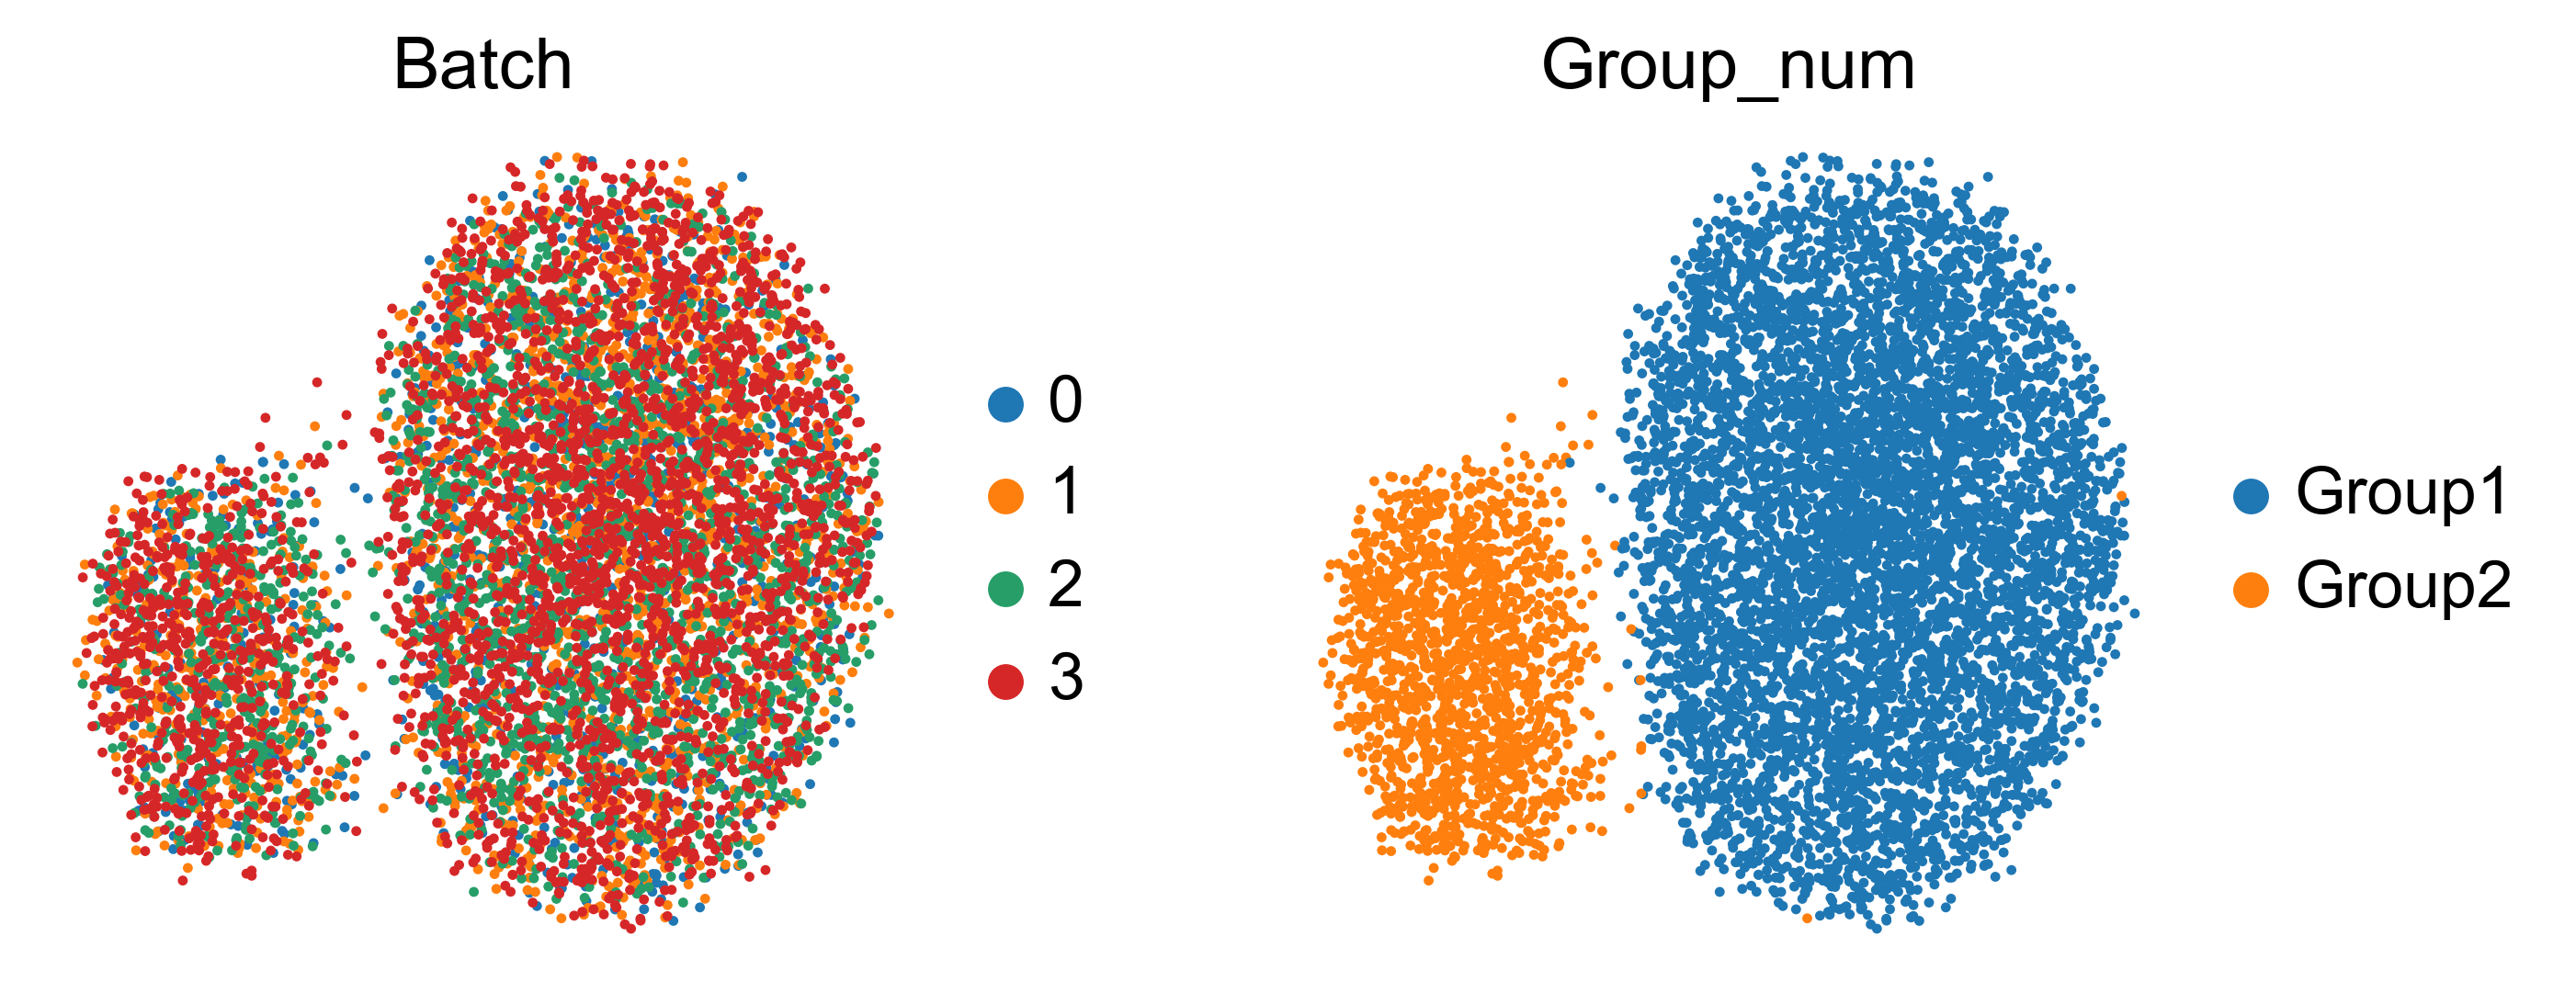

In [70]:
# adata.obsm["X_latent"] = output_results

# sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=30)
# sc.external.pp.bbknn(adata, batch_key='batch', use_rep='X_latent')
# sc.tl.umap(adata)
sc.pl.umap(adata, color=["Batch","Group_num"],
           palette=sc.pl.palettes.vega_20_scanpy)

In [71]:
# sc.pl.umap(adata, color=["Method","CellType"],
#            palette=sc.pl.palettes.vega_20_scanpy)

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


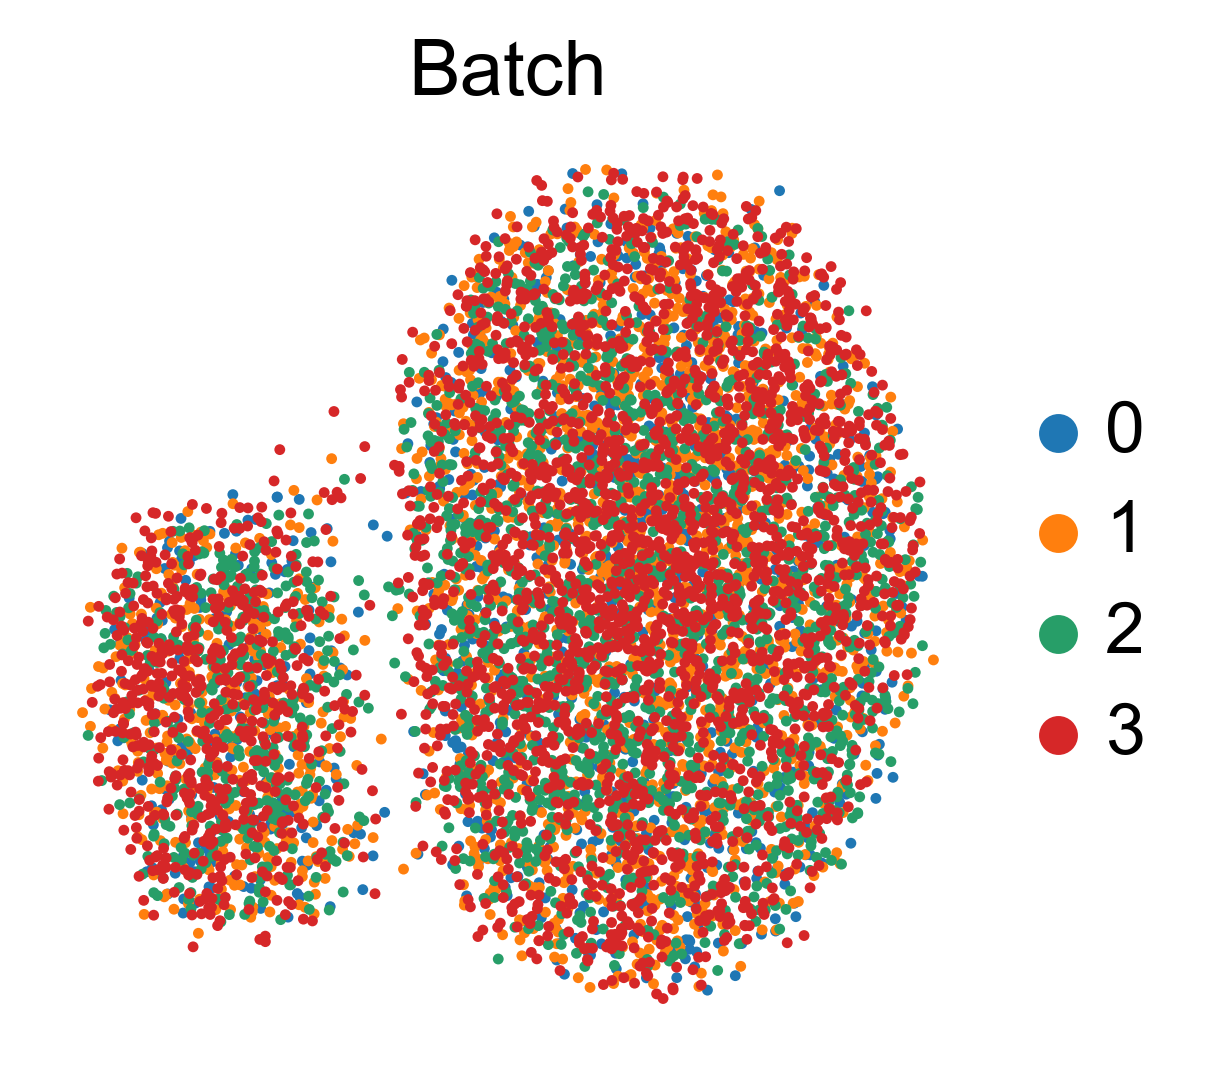

In [72]:
sc.pl.umap(adata, color=["Batch"],
           palette=sc.pl.palettes.vega_20_scanpy)

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


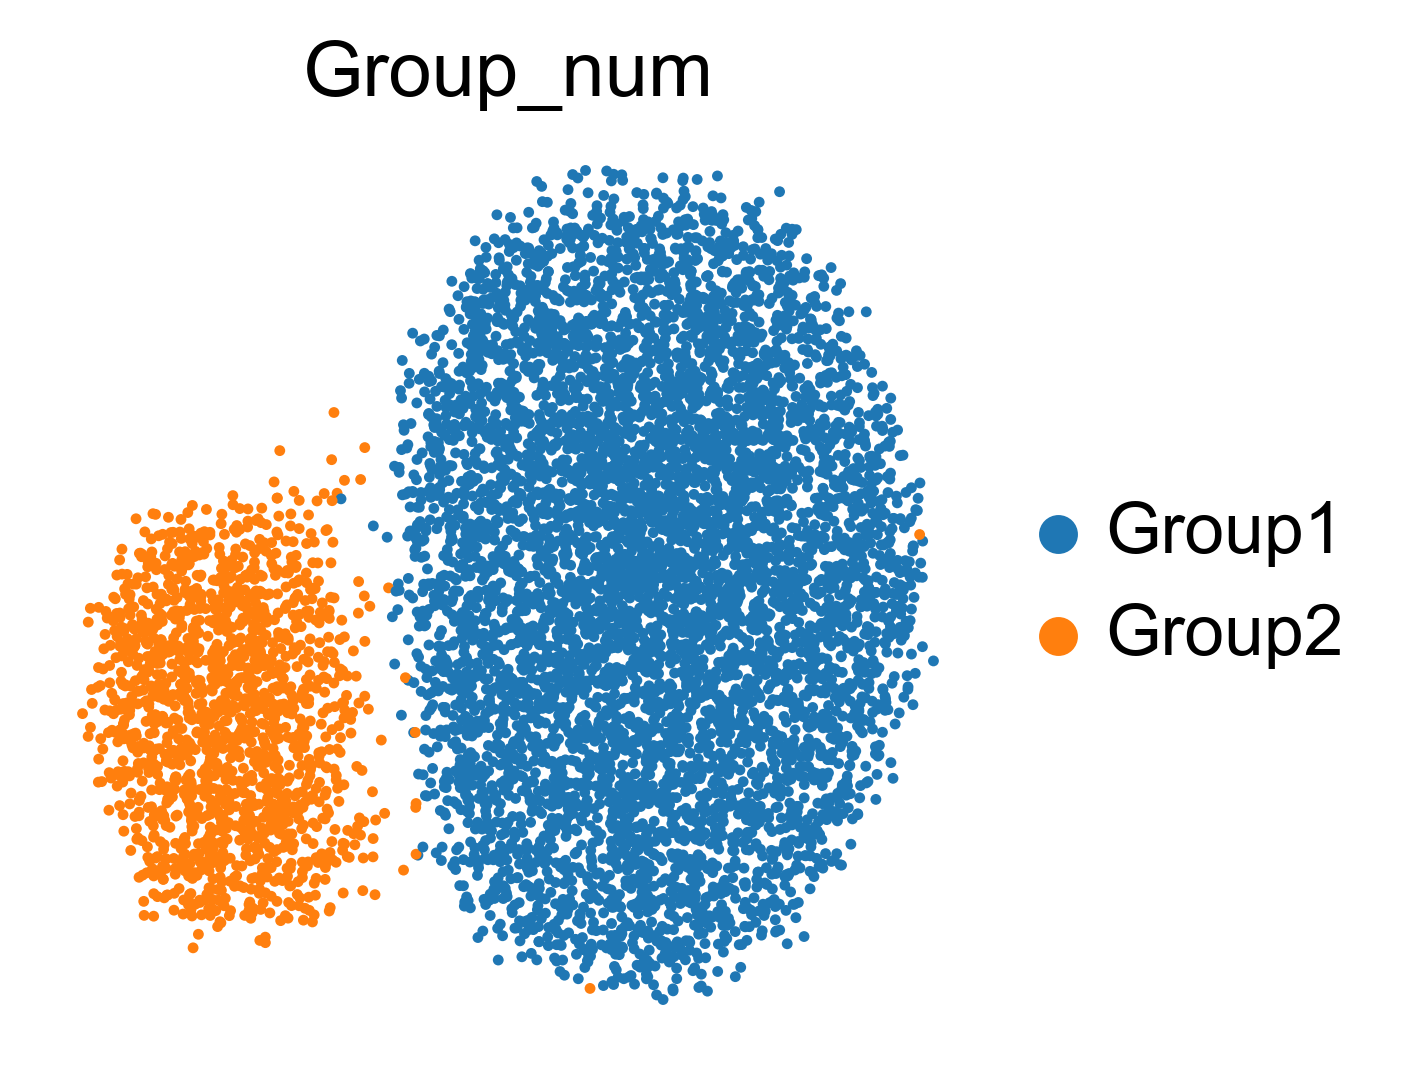

In [73]:
sc.pl.umap(adata, color=["Group_num"],
           palette=sc.pl.palettes.vega_20_scanpy)

In [74]:
adata

AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'log1p', 'neighbors', 'umap', 'Batch_colors', 'Group_num_colors'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    layers: 'counts', 'log_norm', 'X_raw'
    obsp: 'distances', 'connectivities'

In [75]:
compute_ari(adata)

0.9947350781743248

In [76]:
# compute for the percentage of the condition

group_1_per = (adata.obs["Group"] == 0).sum() / len(adata)
group_2_per = (adata.obs["Group"] == 1).sum() / len(adata)
percent_zeros = (adata.X == 0).mean()

print("Group 1 percentage: %s", group_1_per)
print("Group 2 percentage: %s", group_2_per)
print("Zeros percentage: %s", percent_zeros)

Group 1 percentage: %s 0.8025598783424154
Group 2 percentage: %s 0.1974401216575846
Zeros percentage: %s 0.9386664334572393


In [77]:
from scipy.stats import wasserstein_distance
dataset = "simul11_dropout_47_b1_1000_b2_2000"

# true_down_genes_df = pd.read_csv('%s/true_down_genes.txt' % (dataset), sep="\t")
# true_up_genes_df = pd.read_csv('%s/true_up_genes.txt' % (dataset), sep="\t")
true_counts = pd.read_csv('%s/counts.txt' % (dataset), sep="\t").values.transpose()

true_counts = true_counts.astype('float')

true_counts = sc.pp.normalize_per_cell(true_counts, counts_per_cell_after=1e4, copy = True)
true_counts = np.log1p(true_counts)

subset_index = [int(each[4:]) - 1 for each in adata.obs.index.values]
subset_genes = [int(each[4:]) - 1 for each in adata.var.index.values]
true_counts = true_counts[subset_index]
true_counts = true_counts[:, subset_genes]
true_counts = true_counts.flatten()

raw_data = adata.layers["X_raw"].copy().flatten()
corrected_data = adata.obsm["X_latent"].copy().flatten()

# for scanorama
# corrected_data = adata_int.X.toarray().copy().flatten()

wasserstein_distance(corrected_data, true_counts)

0.05262348435734298

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(true_counts, corrected_data)

0.5314618832021258

In [104]:
# adata.write_h5ad("rom_model_pbmc(updated).h5ad")
# adata.write_h5ad("genex_simulation_1_temp.h5ad")

In [80]:
# from sklearn.decomposition import PCA

# X_raw = adata.X

# pca = PCA(n_components = 50, random_state = 8)

# pca.fit(X_raw)

# X_pca_raw = pca.transform(X_raw)

# adata.obsm["X_pca_raw"] = X_pca_raw.copy()

In [81]:
# sc.pp.neighbors(adata, use_rep='X_pca_raw', n_neighbors=30)
# # sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
# sc.tl.umap(adata)

In [82]:
# # custom_palette = cc.glasbey_category10

# sc.pl.umap(adata, color=["Batch"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [83]:
# sc.pl.umap(adata, color=["Group_num"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [84]:
# import scipy.special
# from sklearn.metrics.cluster import adjusted_rand_score


# def ari(adata, group1, group2, implementation="sklearn"):
#     """Adjusted Rand Index
#     The function is symmetric, so group1 and group2 can be switched
#     For single cell integration evaluation the comparison is between predicted cluster
#     assignments and the ground truth (e.g. cell type)
#     :param adata: anndata object
#     :param group1: string of column in adata.obs containing labels
#     :param group2: string of column in adata.obs containing labels
#     :param implementation: if set to 'sklearn', uses sklearn's implementation,
#         otherwise native implementation is taken
#     """

#     group1 = adata.obs[group1].to_numpy()
#     group2 = adata.obs[group2].to_numpy()

#     if len(group1) != len(group2):
#         raise ValueError(
#             f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
#         )

#     return adjusted_rand_score(group1, group2)

# def compute_ari(adata):

#     resolutions = None

#     if resolutions is None:
#         n = 20
#         resolutions = [2 * x / n for x in range(1, n + 1)]

#     score_max = 0
#     res_max = resolutions[0]
#     clustering = None
#     score_all = []
#     use_rep = "X_pca_raw"
#     cluster_key = "louvain"
#     label_key = "Group"
    
#     sc.pp.neighbors(adata, use_rep=use_rep)

#     for res in resolutions:
#         sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
#         score = ari(adata, label_key, cluster_key)
#         score_all.append(score)
#         if score_max < score:
#             score_max = score
#             res_max = res
#             clustering = adata.obs[cluster_key]

#     return score_max

In [85]:
# compute_ari(adata)

In [86]:
# clear GPU
import torch
torch.cuda.empty_cache()

In [87]:
# sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=30)
# # sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=['Method', 'CellType'],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [88]:
# adata_ = adata[adata.obs["Method"] == "10X_5prime"]

# sc.pl.umap(adata_, color=['CellType'],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [89]:
# adata_ = adata[adata.obs["Method"] == "10X_3prime"]

# sc.pl.umap(adata_, color=['CellType'],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [90]:
# corrected_df = pd.DataFrame(adata.obsm["X_latent"].transpose())
# corrected_df.index = adata.var["gene_name"]
# corrected_df.columns = adata.obs.index

# corrected_df

In [91]:
# corrected_df.to_csv("rom_model_corrected_expr.csv")

In [92]:
# one_cell_df_corrected = pd.DataFrame(corrected_df.loc["CD79A"])
# one_cell_df_corrected["CellType"] = adata.obs["CellType"]
# # one_cell_df_corrected.to_csv("CD79A_corrected.csv")

In [93]:
# raw_df = pd.DataFrame(adata.layers["log_norm"].copy().transpose())
# raw_df.index = adata.var["gene_name"]
# raw_df.columns = adata.obs.index

# raw_df

In [94]:
# one_cell_df_raw = pd.DataFrame(raw_df.loc["CD79A"])
# one_cell_df_raw["CellType"] = adata.obs["CellType"]
# # one_cell_df_raw.to_csv("CD79A_raw.csv")

In [95]:
# import torch

# # Define two 1D distributions as PyTorch tensors
# distribution1 = torch.tensor([0.1, 0.2, 0.3, 0.4])
# distribution2 = torch.tensor([0.4, 0.3, 0.2, 0.1])

# # Sort the distributions in ascending order
# distribution1_sorted, indices1 = torch.sort(distribution1)
# distribution2_sorted, indices2 = torch.sort(distribution2)

# # Compute the Wasserstein distance
# wasserstein_distance = torch.abs(distribution1_sorted - distribution2_sorted).sum()

# print(f"Wasserstein Distance: {wasserstein_distance}")


In [96]:
# import torch
# import torch.nn.functional as F

# def swd_loss(data1, data2, n_slices=128):
#     """
#     Custom Slice-Wasserstein Distance (SWD) loss for 1D data.

#     Args:
#         data1 (Tensor): 1D data tensor of shape (batch_size, sequence_length).
#         data2 (Tensor): 1D data tensor of the same shape as data1.
#         n_slices (int): Number of slices to divide the data into.

#     Returns:
#         Tensor: SWD-like loss value.
#     """
#     batch_size, sequence_length = data1.shape

#     # Calculate the slice size to ensure even slicing
#     slice_size = sequence_length // n_slices

#     # Create slices (patches) of data
#     data1_slices = data1.unfold(1, slice_size, 1)
#     data2_slices = data2.unfold(1, slice_size, 1)

#     # Calculate the mean and standard deviation of each slice
#     mean_data1 = torch.mean(data1_slices, dim=2)
#     std_data1 = torch.std(data1_slices, dim=2)
#     mean_data2 = torch.mean(data2_slices, dim=2)
#     std_data2 = torch.std(data2_slices, dim=2)

#     # Calculate Wasserstein distance-like term between means and standard deviations
#     wasserstein_mean = torch.mean(torch.abs(mean_data1 - mean_data2))
#     wasserstein_std = torch.mean(torch.abs(std_data1 - std_data2))

#     # Combine the two Wasserstein-like terms into a single loss
#     swd_like_loss = wasserstein_mean + wasserstein_std

#     return swd_like_loss

# # Example usage:
# data1 = torch.randn(64, 100)  # Replace with your 1D data tensors
# data2 = torch.randn(64, 100)
# loss = swd_loss(data1, data2)
# loss
# # Perform gradient descent to minimize the loss during adversarial training.

In [97]:
# import torch.nn.functional as F
# kl_loss = nn.KLDivLoss(reduction="batchmean")
# # input should be a distribution in the log space
# input = F.log_softmax(torch.randn(3, 5, requires_grad=True), dim=1)
# # Sample a batch of distributions. Usually this would come from the dataset
# target = F.softmax(torch.rand(3, 5), dim=1)
# output = kl_loss(input, target)

In [98]:
# input

In [99]:
# target

In [100]:
# # Define the colorcet paletteasdasd
# custom_palette = cc.glasbey_category10

# ax = sc.pl.umap(adata, color='Batch_num', palette=custom_palette,
#            frameon=False, legend_fontsize=3.5, show=False)

# # Set the plot title with the desired font size
# ax.set_title('Predicted Cell Type', fontsize=6)

# # Adjust the legend font size
# handles, labels = plt.gca().get_legend_handles_labels()

# # Adjust the size of the circles
# for handle in handles:
#     handle.set_sizes([12])
#     handle.set_edgecolor('black')
#     handle.set_linewidth(0.5)

# # Move the legend to the right side of the plot
# plt.legend(handles=handles, labels=labels, prop={'size': 5}, ncol = 1, 
#            loc='upper center', bbox_to_anchor=(0.5, -0.08))

# # Show the plot
# plt.show()

In [101]:
# import numpy as np
# import matplotlib.pyplot as plt

# heatmap_data = np.random.rand(6, 6)  # Generates random values between 0 and 1

# plt = sns.heatmap(heatmap_data, cmap = "YlGn", cbar = False, linewidth=.6, linecolor = "lightgrey")
# plt.grid(False)
# plt.axis(False)

In [102]:
w = torch.empty(3, 5)
nn.init.sparse_(w, sparsity=0.1)

tensor([[ 0.0000, -0.0088, -0.0103,  0.0000,  0.0010],
        [-0.0023, -0.0016,  0.0061, -0.0053,  0.0000],
        [ 0.0170,  0.0000,  0.0000, -0.0102, -0.0144]])